In [ ]:
!git clone http://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (6/6), done.


In [ ]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [ ]:
np.random.seed(0)

In [ ]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)

print(type(train_data))

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']



<class 'dict'>


In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [ ]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels" 
assert(X_train.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dimensions of the images are not 32 x 32 x 3"

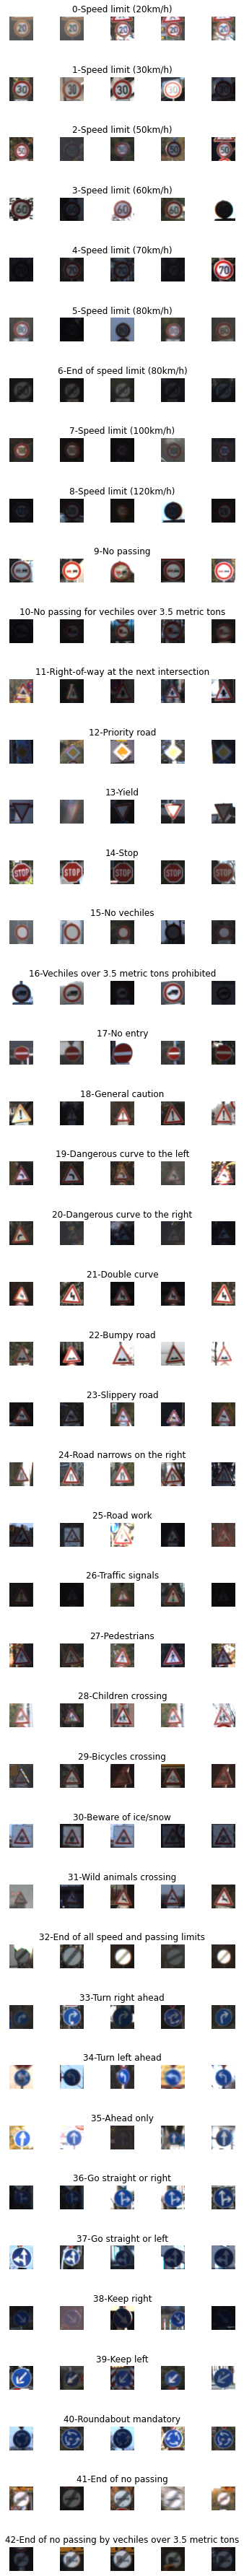

In [ ]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize= (5,50))
fig.tight_layout()

for i in range(cols):
  for j, row in data.iterrows():
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i == 2:
      axs[j][i].set_title(str(j) + "-" + row["SignName"])
      num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


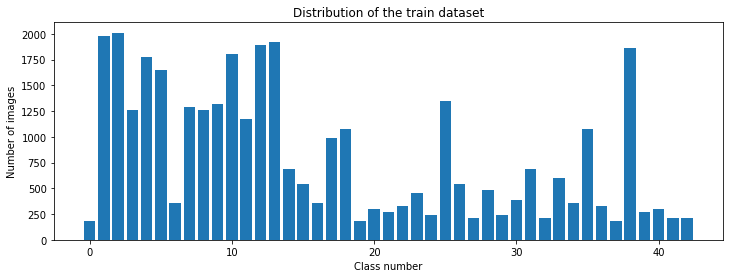

In [ ]:
print(num_of_samples)
plt.figure(figsize = (12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


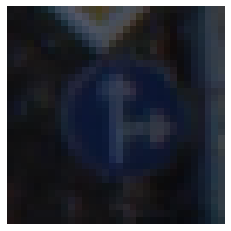

In [ ]:
import cv2
 
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])


(-0.5, 31.5, 31.5, -0.5)

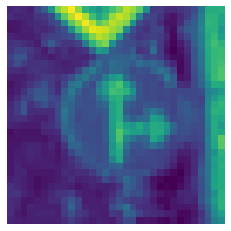

In [ ]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")

(32, 32)


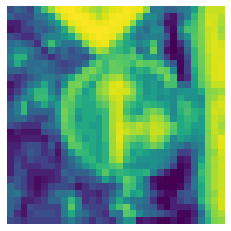

In [ ]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)


In [ ]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img
  
X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


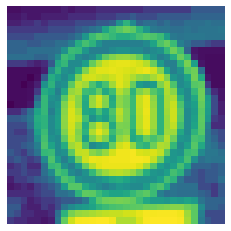

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [ ]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [ ]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

(15, 32, 32, 1)


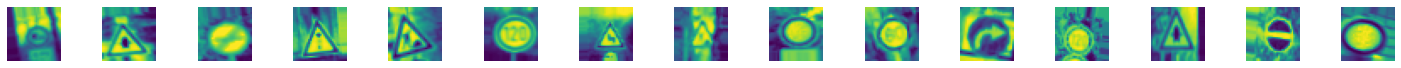

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
 
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)
 
datagen.fit(X_train)
# for X_batch, y_batch in
 
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)
 
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
 
for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
 
print(X_batch.shape)

In [ ]:
def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))
  
  model.compile(Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model
model = modified_model()
print(model.summary())
 
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=150,
                            epochs=15,
                            validation_data=(X_val, y_val), shuffle = 1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 60)        1560      
                                                                 
 conv2d_13 (Conv2D)          (None, 24, 24, 60)        90060     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 60)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 10, 10, 30)        16230     
                                                                 
 conv2d_15 (Conv2D)          (None, 8, 8, 30)          8130      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 4, 4, 30)         0         
 2D)                                                  

<ipython-input-20-19104645950d>:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),


150/150 [==============================] - 94s 624ms/step - loss: 3.2989 - accuracy: 0.1188 - val_loss: 2.0899 - val_accuracy: 0.4664
Epoch 2/15
150/150 [==============================] - 98s 657ms/step - loss: 1.8737 - accuracy: 0.4536 - val_loss: 0.9717 - val_accuracy: 0.6680
Epoch 3/15
150/150 [==============================] - 94s 629ms/step - loss: 1.2288 - accuracy: 0.6193 - val_loss: 0.5018 - val_accuracy: 0.8383
Epoch 4/15
150/150 [==============================] - 98s 652ms/step - loss: 0.9122 - accuracy: 0.7158 - val_loss: 0.3997 - val_accuracy: 0.8678
Epoch 5/15
150/150 [==============================] - 94s 628ms/step - loss: 0.7366 - accuracy: 0.7708 - val_loss: 0.2611 - val_accuracy: 0.9206
Epoch 6/15
150/150 [==============================] - 98s 653ms/step - loss: 0.5693 - accuracy: 0.8236 - val_loss: 0.2144 - val_accuracy: 0.9388
Epoch 7/15
150/150 [==============================] - 101s 675ms/step - loss: 0.5163 - accuracy: 0.8493 - val_loss: 0.1622 - val_accuracy: 0.

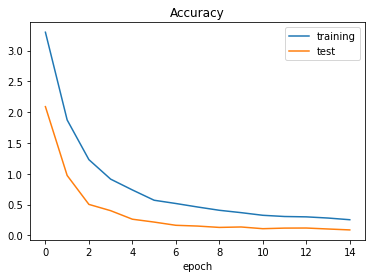

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
 


plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')
 
score = model.evaluate(X_test, y_test, verbose=0)

Test score: 0.1781010925769806
Test accuracy: 0.9494061470031738


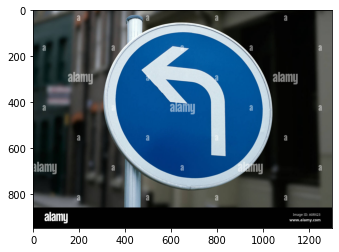

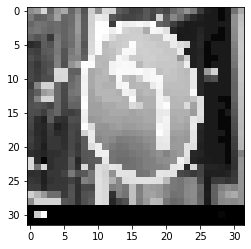

(32, 32)
1/1 [==============================] - 0s 24ms/step
predicted sign class is 34 which is 'Turn left ahead'


In [ ]:
print('Test score:', score[0])
print('Test accuracy:', score[1])
 
#predict internet number
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))
plt.show()
 
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
plt.show()
print(img.shape)
img = img.reshape(1, 32, 32, 1)

# print(model.predict(img))
output= np.argmax(model.predict(img))
print("predicted sign class is {} which is '{}'".format(output, data.iloc[output].SignName))
